# NLP-Facebook-Sentiment-Analyis-2

# Imports

In [63]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re

from nltk.tokenize import word_tokenize

from transformers import AutoTokenizer


from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.preprocessing import LabelEncoder

import tensorflow as tf
from tensorflow.keras.layers import Dense, Embedding, LSTM, Bidirectional
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Functions

In [64]:
def check_for_nulls_dupes(df):
  print(f"The amount of NaN values: {df.isna().sum()}")
  print(f"The amount of Duplicated values: {df.duplicated().sum()}")

def check_class_imbalance(target):
  
  unique, counts = np.unique(target, return_counts=True)
  plt.figure(figsize=(10, 7))
  plt.pie(counts, labels=unique, autopct="%1.1f%%", startangle=140)
  plt.title("Target Class Breakdown")
  plt.legend()
  plt.show()
  
  plt.figure(figsize=(10, 7))
  sns.countplot(x=target)
  plt.title("Target Class Breakdown")
  plt.xlabel("Target Class")
  plt.ylabel("Counts")
  plt.xticks(rotation=45)
  plt.show()

def remove_stop_words(content):
  word_tokens = " ".join(word_tokenize(content))
  filtered_tokens = re.sub(r"[^a-zA-Z\s]", "", word_tokens).split(" ")
  filtered_word_tokens = [w.lower().strip() for w in filtered_tokens if w.lower() not in ENGLISH_STOP_WORDS]
  return " ".join(filtered_word_tokens).strip()

def plot_learning_curves(history):
  acc, val_acc = history.history["accuracy"], history.history["val_accuracy"]
  loss, val_loss = history.history["loss"], history.history["val_loss"]
  epochs = range(1, len(acc)+1)
  
  plt.figure(figsize=(10, 7))
  plt.subplot(1,2,1)
  plt.plot(epochs, acc, "bo-", label="Training Acc")
  plt.plot(epochs, val_acc, "gs-", label="Val Acc")
  plt.title("Training and Val Acc")
  plt.xlabel("Epochs")
  plt.ylabel("Acc")
  plt.legend()
  plt.xticks(rotation=45)
  
  plt.subplot(1,2,2)
  plt.plot(epochs, loss, "bo-", label="Training Loss")
  plt.plot(epochs, val_loss, "gs-", label="Val Loss")
  plt.title("Training and Val Loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.xticks(rotation=45)
  
  plt.tight_layout()
  plt.show()

# EDA Analysis

In [65]:
df = pd.read_csv("/Users/maukanmir/Downloads/facebook_reviews.csv", nrows=15000)
df

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,appVersion
0,bdc80475-1569-4ab7-941d-1418df2037a9,Joyce A Shultz,Very good,5,3,462.0.0.47.85,2024-06-05 04:34:12,462.0.0.47.85
1,c730747d-e911-4f2a-9361-a1512d0a618a,Keran Rigby,KarenRigby,5,2,NaN,2024-06-04 14:36:57,NaN
2,0c63a71b-c9b4-4219-a123-38f95028e09b,MD Mahbub,D Good,5,0,NaN,2024-06-03 17:21:39,NaN
3,5c78dff6-df96-4b0d-b7b1-6e3b7d0604b4,Rodolfo Sanotajr,Jayar sanotajr,5,0,NaN,2024-06-03 12:13:41,NaN
4,29096648-1c2d-4252-b943-a51e99e21ec6,Fidaullah Gilgit,Good,5,1,466.1.0.57.85,2024-06-02 17:11:55,466.1.0.57.85
...,...,...,...,...,...,...,...,...
14995,53241d17-68c0-4ccc-b1fa-5cd37c4fc1b5,Rajat Sharma,This is great for avaretime,5,0,426.0.0.26.50,2024-05-22 04:34:25,426.0.0.26.50
14996,50afc6a7-0b6b-4982-a66e-4690a6f8030b,Umme kulsum Shikha,Minhaz,5,0,436.0.0.35.101,2024-05-22 04:33:52,436.0.0.35.101
14997,c8e989e7-2269-42e0-862f-7a612517eb9a,Venedict Tulaylay,Very nice,5,0,NaN,2024-05-22 04:33:26,NaN
14998,af9d5c44-f80d-4868-af6a-5739d9886294,Abdin Ali,madibur,5,0,276.0.0.44.127,2024-05-22 04:33:12,276.0.0.44.127


# Check For Nulls and Dupes

In [66]:
check_for_nulls_dupes(df)

The amount of NaN values: reviewId                   0
userName                   0
content                    0
score                      0
thumbsUpCount              0
reviewCreatedVersion    2620
at                         0
appVersion              2620
dtype: int64
The amount of Duplicated values: 0


In [67]:
df.dropna(inplace=True)

In [68]:
df.drop_duplicates(inplace=True)

In [69]:
df.shape

(12380, 8)

# Check For Class Imbalance

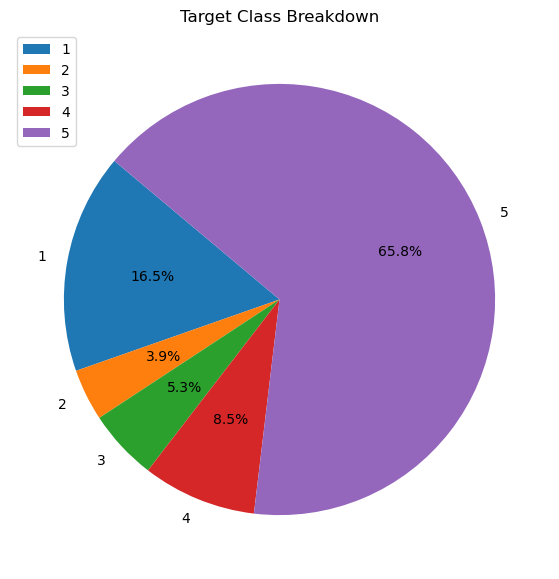

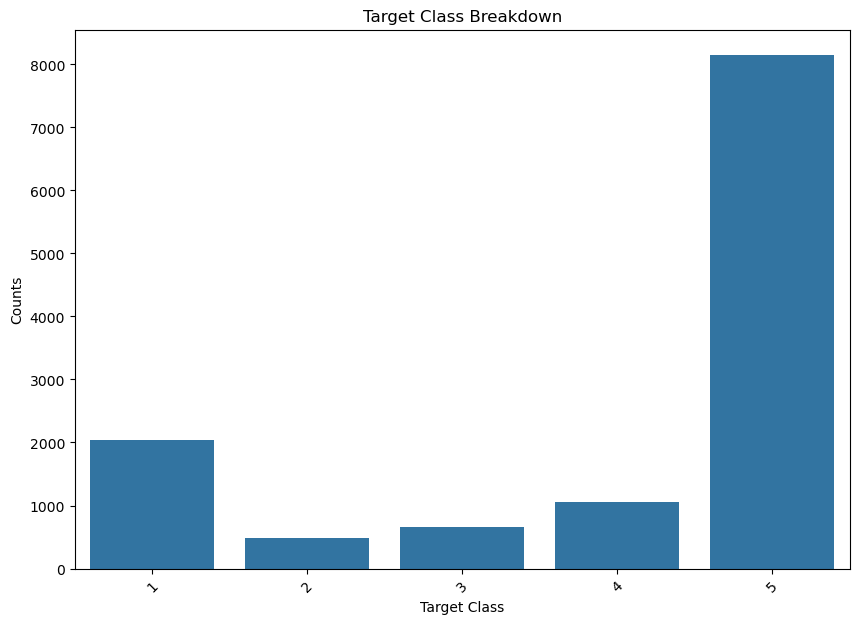

In [70]:
check_class_imbalance(df["score"])

# Class Imbalance exists

In [71]:
df.dtypes

reviewId                object
userName                object
content                 object
score                    int64
thumbsUpCount            int64
reviewCreatedVersion    object
at                      object
appVersion              object
dtype: object

# Drop Unused Columns

In [72]:
df.drop(["reviewId", "userName", "reviewCreatedVersion", "appVersion"],axis=1, inplace=True)

In [73]:
df.describe()

,score,thumbsUpCount
count,12380.000000,12380.000000
mean,4.032714,1.593215
std,1.532473,48.029967
min,1.000000,0.000000
25%,3.000000,0.000000
50%,5.000000,0.000000
75%,5.000000,0.000000
max,5.000000,3347.000000


# Data Preprocessing

In [74]:
df["content"] = df["content"].apply(remove_stop_words)

In [75]:
df["score"] = df["score"].apply(lambda x: 0 if x <=3 else 1)

<AxesSubplot:xlabel='Positive Review', ylabel='Negative Review'>

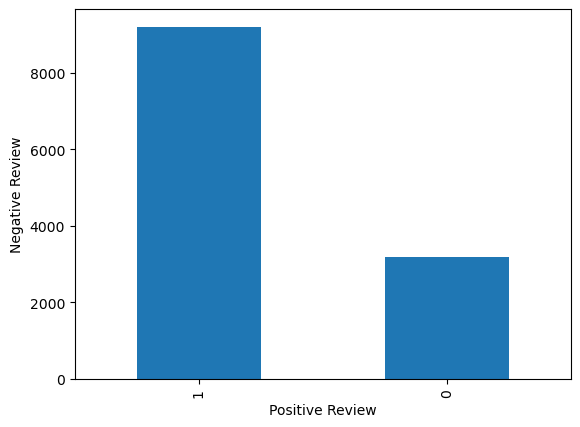

In [76]:
df["score"].value_counts().plot.bar(xlabel="Positive Review", ylabel="Negative Review")

# Check for empty Strings

In [77]:
df = df[df['content'].str.strip() != '']

# Separate Feature Variables

In [78]:
X, y = df["content"], df["score"]

# Establish Bert Model

In [79]:
model = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model)

# Tokenize Content

In [80]:
seq = X.tolist()
model_inputs = tokenizer(seq, padding=True, return_tensors="tf")

In [81]:
vocab_size = len(tokenizer.get_vocab()) +1
vocab_size

30523

# Create LSTM Model

In [82]:
model = Sequential()
model.add(Embedding(input_dim=vocab_size, output_dim=32))
model.add(Bidirectional(LSTM(32, activation="tanh")))
model.add(Dense(128, activation="relu"))
model.add(Dense(256, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, None, 32)          976736    
                                                                 
 bidirectional_3 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_13 (Dense)            (None, 128)               8320      
                                                                 
 dense_14 (Dense)            (None, 256)               33024     
                                                                 
 dense_15 (Dense)            (None, 128)               32896     
                                                                 
 dense_16 (Dense)            (None, 1)                 129       
                                                      

In [83]:
dataset = tf.data.Dataset.from_tensor_slices((model_inputs["input_ids"], y))

In [84]:
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [85]:
len_df = len(dataset)

train = dataset.take(int(len_df *.7))
test = dataset.skip(int(len_df *.7)).take(int(len_df *.2))
val =  dataset.skip(int(len_df *.9)).take(int(len_df *.1))

# Early Stopping Metric

In [86]:
early_stopping = EarlyStopping(
  monitor="val_loss",
  min_delta=0.01,
  restore_best_weights=True,
  patience=10,
  verbose=0,
  mode="min"
)

# Train Model

In [87]:
history = model.fit(
  train,
  validation_data=val,
  epochs=100,
  batch_size=16,
  verbose=0,
  callbacks=[early_stopping]
)

# Learning Curves

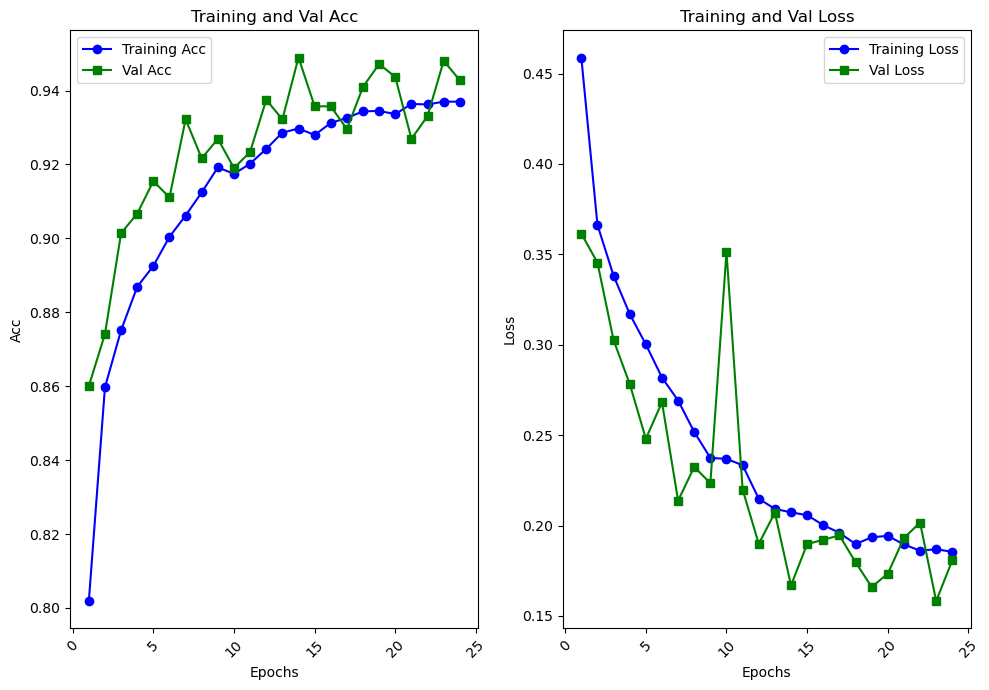

In [88]:
plot_learning_curves(history)

In [89]:
loss, test_acc = model.evaluate(test, steps=100)
print(f"The Loss is: {loss}, Test Acc: {test_acc}")

100/100 [==============================] - 1s 5ms/step - loss: 0.2017 - accuracy: 0.9281
The Loss is: 0.20166869461536407, Test Acc: 0.9281250238418579


# Create Pred Data

In [90]:
pred_data = []
for i in range(0, 2):
  content = df[df["score"] == i].iloc[0]["content"]
  pred_data.append(content)

In [91]:
pred_data

['ads  just takes used enjoyable app   really use dark mode tablet version better viewing experience landscape mode mention really use thumbs option',
 'good']

In [94]:
pred_labels = [0,1]

pred_inputs = tokenizer(pred_data, padding=True, return_tensors="tf")
test_dataset = tf.data.Dataset.from_tensor_slices((pred_inputs["input_ids"], pred_labels))
test_dataset = test_dataset.batch(32)

preds = model.predict(test_dataset)
pred_classes = tf.argmax(preds, axis=1)
print(pred_classes.numpy())

1/1 [==============================] - 0s 6ms/step
[0 0]
